In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import xgboost as xgb
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV,TimeSeriesSplit

In [2]:
def rmspe(y_true,y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    mask = y_true != True
    y_true_filtered = y_true[mask]
    y_pred_filtered = y_pred[mask]

    if len(y_true_filtered) == 0:
        return float('inf')

    return np.sqrt(np.mean(np.square((y_true_filtered-y_pred_filtered)/y_true_filtered)))*100

In [3]:

paths = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if str(filename) == 'sample_submission.csv' or str(filename) == 'store.csv':
            if str(filename) == 'store.csv':
                store_data_path = Path(os.path.join(dirname, filename))
            continue
        print(os.path.join(dirname, filename))
        paths.append(Path(os.path.join(dirname, filename)))

/kaggle/input/rossmann-store-sales/train.csv
/kaggle/input/rossmann-store-sales/test.csv


In [4]:
dat = {}
for i in paths:
    with open(i,'r') as f:
        dat[i.stem] = pd.read_csv(f,low_memory=False)

In [5]:
with open(store_data_path,'r') as f:
    store_data = pd.read_csv(f)

In [6]:
for i in dat:
    dat[i]['Date'] = pd.to_datetime(dat[i]['Date'])
    dat[i]["Year"] = dat[i]["Date"].dt.year
    dat[i]["Month"] = dat[i]["Date"].dt.month
    dat[i]["Day"] = dat[i]["Date"].dt.day
    dat[i]["Weekday"] = dat[i]["Date"].dt.weekday
    dat[i].drop("Date", axis=1, inplace=True)
    dat[i].drop("StateHoliday", axis=1, inplace=True)

In [7]:
store_data = store_data.fillna(store_data.mean(numeric_only=True))
# store_data = store_data.drop(['PromoInterval'],axis = 1)
# for col in ['StoreType', 'Assortment']:
#     store_data[col], _ = pd.factorize(store_data[col])
store_data = pd.get_dummies(store_data, columns=['StoreType', 'Assortment','PromoInterval'])

In [8]:
dat['train'] = pd.merge(dat['train'], store_data, on="Store", how="left")

In [9]:
X = dat['train'].drop(["Sales",'Customers'], axis=1)
y = dat['train']['Sales']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
rmse_scorer = make_scorer(mean_squared_error, squared=False, greater_is_better=False)

model = xgb.XGBRegressor()

tscv = TimeSeriesSplit(n_splits=5)

In [11]:
search = xgb.XGBRegressor(
    device='cuda',
    subsample=0.6,
    reg_lambda=5,
    reg_alpha=0,
    n_estimators=500,
    max_depth=10,
    learning_rate=0.1,
    gamma=1,
    colsample_bytree=1.0
)

In [12]:
# best_features = ['Store', 'Open', 'Promo', 'SchoolHoliday', 'Year', 'Month', 'Day', 'Weekday', 'StoreType_a', 'StoreType_b', 'StoreType_c', 'StoreType_d', 'Assortment_a', 'Assortment_b', 'Assortment_c', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear']


In [13]:
dat['test'] = pd.merge(dat['test'], store_data, on="Store", how="left")

In [14]:
search.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=1, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [12:55:04] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


RMSE: 657.5363769245085 ,


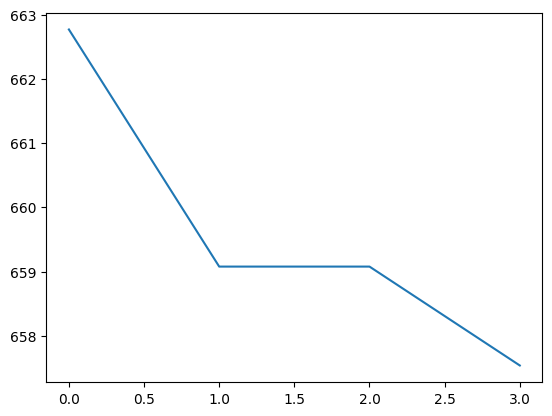

In [15]:
y_pred = search.predict(X_val)

y_pred = np.maximum(0, y_pred)
y_test = np.maximum(0, y_val)

rmse_value = np.sqrt(mean_squared_error(y_test, y_pred))

print("RMSE:", rmse_value,',')
#RMSLE: 662.7738319695426
#RMSLE: 659.0778028080498
#RMSE: 659.0778028080498
plt.plot([662.7738319695426,
          659.0778028080498,
          659.0778028080498,
          657.5363769245085,

])
plt.show()

In [16]:
X_test = dat['test']

submission = pd.DataFrame()

submission['Id'] = X_test['Id']

submission['Sales'] = search.predict(X_test.drop(columns=['Id'])).clip(0)

submission.to_csv("submission.csv", index=False)
